# Data Dictionary:
The variables can be classified into 3 broader categories:
## Demographic information about customers
customer_id - Customer id

vintage - Vintage of the customer with the bank in number of days

age - Age of customer

gender - Gender of customer

dependents - Number of dependents

occupation - Occupation of the customer

city - City of customer (anonymised)

## Customer Bank Relationship
customer_nw_category - Net worth of customer (3:Low 2:Medium 1:High)

branch_code - Branch Code for customer account

days_since_last_transaction - No of Days Since Last Credit in Last 1 year

## Transactional Information
current_balance - Balance as of today

previous_month_end_balance - End of Month Balance of previous month

average_monthly_balance_prevQ - Average monthly balances (AMB) in Previous Quarter

average_monthly_balance_prevQ2 - Average monthly balances (AMB) in previous to previous quarter

current_month_credit - Total Credit Amount current month

previous_month_credit - Total Credit Amount previous month

current_month_debit - Total Debit Amount current month

previous_month_debit - Total Debit Amount previous month

current_month_balance - Average Balance of current month

previous_month_balance - Average Balance of previous month

churn - Average balance of customer falls below minimum balance in the next quarter (1/0)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve,accuracy_score,precision_score,recall_score
import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)
warnings.simplefilter(action="ignore",category=UserWarning)

In [2]:
df=pd.read_csv("Downloads/churn_prediction.csv")

In [3]:
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


In [4]:
df.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [5]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [6]:
df.shape

(28382, 21)

In [7]:
mapping={'Male':1,'Female':2}
df['gender']=df['gender'].map(mapping)

In [8]:
df['gender']=df['gender'].fillna(-1)

In [9]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
9.0         1
52.0        1
36.0        1
50.0        1
8.0         1
25.0        1
32.0        1
Name: dependents, dtype: int64

In [10]:
df['dependents']=df['dependents'].fillna(0.0)

In [11]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [12]:
df['occupation']=df['occupation'].fillna('self_employed')

In [13]:
df['city'].value_counts()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
748.0        1
1099.0       1
108.0        1
655.0        1
723.0        1
Name: city, Length: 1604, dtype: int64

In [14]:
df['city']=df['city'].fillna(1020)

In [15]:
df['days_since_last_transaction'].value_counts()

0.0      1672
3.0       831
14.0      654
4.0       632
6.0       596
         ... 
309.0       1
225.0       1
183.0       1
92.0        1
334.0       1
Name: days_since_last_transaction, Length: 360, dtype: int64

In [16]:
df['days_since_last_transaction']=df['days_since_last_transaction'].fillna(999)

In [17]:
df['vintage_in_yrs']=df['vintage']/365

In [18]:
num_Cols=[ 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']

In [19]:
df[num_Cols].describe()

,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
count,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04
mean,7.380552e+03,7.495771e+03,7.124209e+03,7.496780e+03,3.433252e+03,3.261694e+03,3.658745e+03,3.339761e+03,7.451133e+03,7.495177e+03
std,4.259871e+04,4.252935e+04,4.457581e+04,4.172622e+04,7.707145e+04,2.968889e+04,5.198542e+04,2.430111e+04,4.203394e+04,4.243198e+04
min,-5.503960e+03,-3.149570e+03,-1.650610e+04,1.428690e+03,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,-3.374180e+03,-5.171920e+03
25%,1.784470e+03,1.906000e+03,1.832507e+03,2.180945e+03,3.100000e-01,3.300000e-01,4.100000e-01,4.100000e-01,1.996765e+03,2.074407e+03
50%,3.281255e+03,3.379915e+03,3.359600e+03,3.542865e+03,6.100000e-01,6.300000e-01,9.193000e+01,1.099600e+02,3.447995e+03,3.465235e+03
75%,6.635820e+03,6.656535e+03,6.517960e+03,6.666887e+03,7.072725e+02,7.492350e+02,1.360435e+03,1.357553e+03,6.667958e+03,6.654693e+03
max,5.905904e+06,5.740439e+06,5.010170e+06,5.700290e+06,1.226985e+07,2.361808e+06,7.637857e+06,1.414168e+06,5.778185e+06,5.720144e+06


In [20]:
df[num_Cols].corr()

,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
current_balance,1.000000,0.947276,0.714600,0.958307,0.030371,0.061754,0.044412,0.081247,0.983412,0.942207
previous_month_end_balance,0.947276,1.000000,0.722998,0.970530,0.032493,0.114222,0.066329,0.109606,0.974714,0.969605
average_monthly_balance_prevQ2,0.714600,0.722998,1.000000,0.763495,0.036271,0.062264,0.045239,0.102519,0.725826,0.736635
average_monthly_balance_prevQ,0.958307,0.970530,0.763495,1.000000,0.033639,0.085699,0.060579,0.121272,0.976290,0.994038
current_month_credit,0.030371,0.032493,0.036271,0.033639,1.000000,0.168561,0.937021,0.135729,0.034182,0.038254
previous_month_credit,0.061754,0.114222,0.062264,0.085699,0.168561,1.000000,0.165092,0.733953,0.085320,0.108496
current_month_debit,0.044412,0.066329,0.045239,0.060579,0.937021,0.165092,1.000000,0.191755,0.069720,0.063375
previous_month_debit,0.081247,0.109606,0.102519,0.121272,0.135729,0.733953,0.191755,1.000000,0.102010,0.139723
current_month_balance,0.983412,0.974714,0.725826,0.976290,0.034182,0.085320,0.069720,0.102010,1.000000,0.963276
previous_month_balance,0.942207,0.969605,0.736635,0.994038,0.038254,0.108496,0.063375,0.139723,0.963276,1.000000


<Axes: xlabel='gender', ylabel='count'>

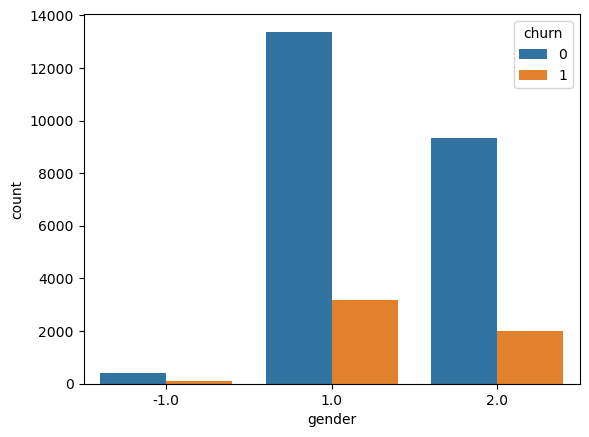

In [21]:
sns.countplot(x='gender',hue='churn',data=df)

Proportion of Males churning out is higher than that of females

<Axes: xlabel='churn', ylabel='count'>

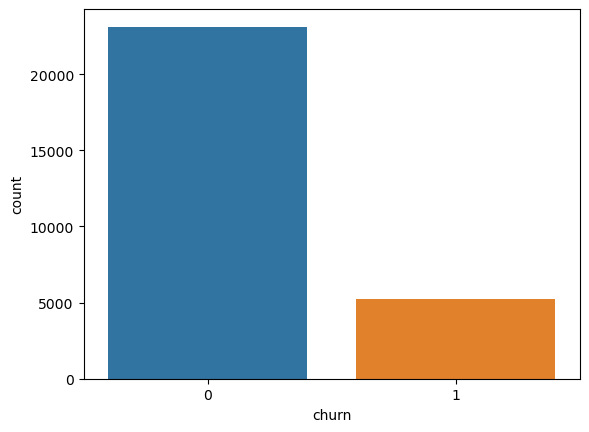

In [22]:
sns.countplot(x='churn',data=df)

<Axes: xlabel='occupation', ylabel='count'>

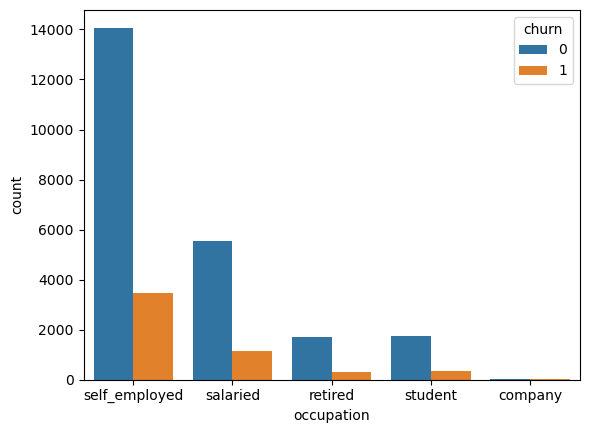

In [23]:
sns.countplot(x='occupation',hue='churn',data=df)

A higher proportion of self employed are the ones churning out as compared to other occupation

In [24]:
t=df['churn'].value_counts(normalize=True)

In [25]:
print('churn percentage:  ',t[1]*100)

churn percentage:   18.532872947642872


<Axes: xlabel='customer_nw_category', ylabel='count'>

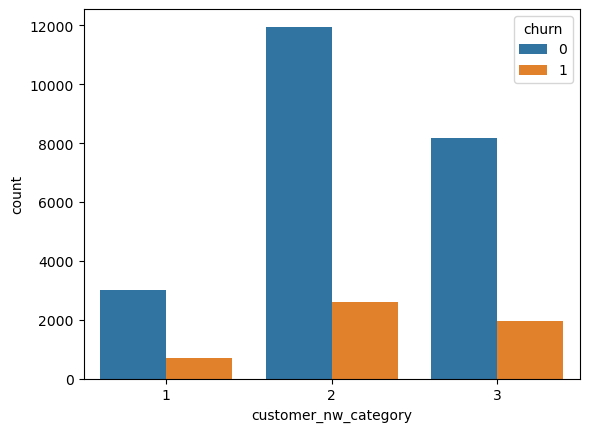

In [26]:
sns.countplot(x='customer_nw_category',hue='churn',data=df)

Customer with net worth category 2:Middle has the higher proportion of churn followed by that of 3:Low

<Axes: xlabel='age', ylabel='Count'>

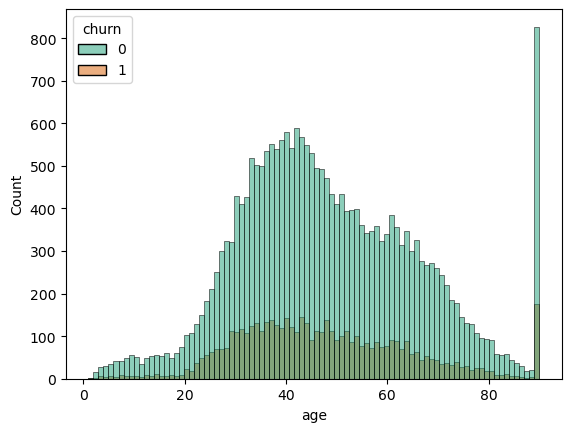

In [27]:
sns.histplot(x='age',hue='churn',data=df,bins=90,palette='Dark2')

The age group between 30-60 has the higher proportion of churn

<Axes: xlabel='vintage_in_yrs', ylabel='Count'>

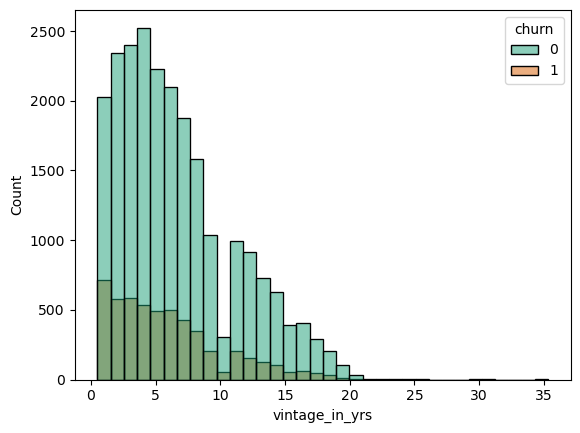

In [28]:
sns.histplot(x='vintage_in_yrs',hue='churn',data=df,bins=34,palette='Dark2')

Customers with vintage <10 years are high to churn

<Axes: xlabel='dependents', ylabel='count'>

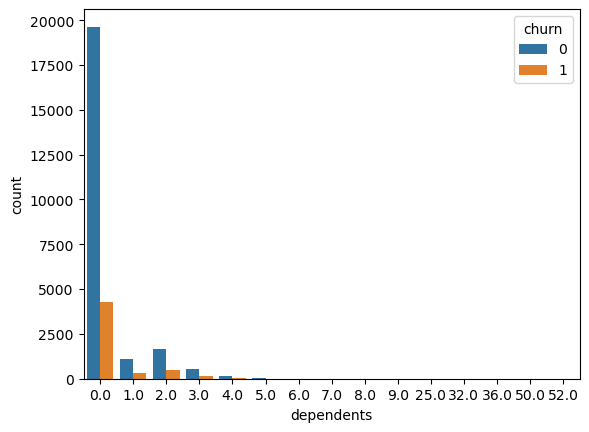

In [29]:
sns.countplot(x='dependents',hue='churn',data=df)

A higher proportion of customers churning have 0 dependents.Dependents is not a crucial variable

In [30]:
df=pd.concat([df,pd.get_dummies(df['occupation'],prefix=str('occupation'),prefix_sep="_")],axis=1)

In [31]:
df.corr()

,customer_id,vintage,age,gender,dependents,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,...,previous_month_debit,current_month_balance,previous_month_balance,churn,vintage_in_yrs,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
customer_id,1.000000,-0.006093,-0.000442,0.004206,-0.009110,0.000669,0.009618,-0.000286,0.001632,0.006589,...,-0.008760,0.005140,0.004553,-0.002723,-0.006093,0.004593,-0.004209,0.002557,0.001260,-0.003035
vintage,-0.006093,1.000000,0.227390,-0.004381,0.068588,0.041720,-0.167366,-0.380714,-0.034482,0.002986,...,0.023949,0.001638,0.003448,-0.064637,1.000000,0.035027,0.057813,0.041924,-0.013189,-0.106399
age,-0.000442,0.227390,1.000000,-0.221436,0.001261,0.014564,-0.076532,-0.058990,-0.020005,0.054346,...,0.033296,0.057662,0.060297,-0.020012,0.227390,0.045605,0.372942,-0.129008,0.153136,-0.452218
gender,0.004206,-0.004381,-0.221436,1.000000,-0.126470,-0.006435,-0.007274,-0.049490,0.050420,-0.049443,...,-0.036912,-0.052933,-0.049788,-0.019897,-0.004381,-0.032866,-0.080699,-0.083605,0.085880,0.060913
dependents,-0.009110,0.068588,0.001261,-0.126470,1.000000,0.003287,0.007917,-0.001704,-0.088345,-0.003838,...,0.030746,-0.002769,-0.001672,0.029335,0.068588,-0.004590,-0.054831,0.044848,0.037310,-0.088262
city,0.000669,0.041720,0.014564,-0.006435,0.003287,1.000000,0.009323,-0.055779,-0.004962,-0.006220,...,0.005448,-0.006355,-0.006318,-0.000883,0.041720,0.002009,-0.004232,0.003649,0.000163,-0.002373
customer_nw_category,0.009618,-0.167366,-0.076532,-0.007274,0.007917,0.009323,1.000000,0.235059,0.025655,-0.058314,...,-0.071721,-0.058648,-0.059113,0.006551,-0.167366,0.002814,0.011718,0.040449,-0.021901,-0.037264
branch_code,-0.000286,-0.380714,-0.058990,-0.049490,-0.001704,-0.055779,0.235059,1.000000,-0.022233,0.000181,...,-0.017584,0.001031,0.002080,0.035469,-0.380714,-0.008184,-0.004395,-0.033180,0.053324,-0.039988
days_since_last_transaction,0.001632,-0.034482,-0.020005,0.050420,-0.088345,-0.004962,0.025655,-0.022233,1.000000,-0.016093,...,-0.061362,-0.015731,-0.013177,-0.096500,-0.034482,0.004372,0.002313,-0.042554,-0.017372,0.099309
current_balance,0.006589,0.002986,0.054346,-0.049443,-0.003838,-0.006220,-0.058314,0.000181,-0.016093,1.000000,...,0.081247,0.983412,0.942207,-0.024181,0.002986,0.000772,-0.006112,0.000760,0.012773,-0.019217


In [32]:
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_debit,current_month_balance,previous_month_balance,churn,vintage_in_yrs,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,1,3135,66,1.0,0.0,self_employed,187.0,2,755,224.0,...,0.20,1458.71,1458.71,0,8.589041,0,0,0,1,0
1,2,310,35,1.0,0.0,self_employed,1020.0,2,3214,60.0,...,100.56,6496.78,8787.61,0,0.849315,0,0,0,1,0
2,4,2356,31,1.0,0.0,salaried,146.0,2,41,999.0,...,259.23,5006.28,5070.14,0,6.454795,0,0,1,0,0
3,5,478,90,-1.0,0.0,self_employed,1020.0,2,582,147.0,...,2143.33,2291.91,1669.79,1,1.309589,0,0,0,1,0
4,6,2531,42,1.0,2.0,self_employed,1494.0,3,388,58.0,...,1538.06,1157.15,1677.16,1,6.934247,0,0,0,1,0


In [33]:
df.dtypes

customer_id                         int64
vintage                             int64
age                                 int64
gender                            float64
dependents                        float64
occupation                         object
city                              float64
customer_nw_category                int64
branch_code                         int64
days_since_last_transaction       float64
current_balance                   float64
previous_month_end_balance        float64
average_monthly_balance_prevQ     float64
average_monthly_balance_prevQ2    float64
current_month_credit              float64
previous_month_credit             float64
current_month_debit               float64
previous_month_debit              float64
current_month_balance             float64
previous_month_balance            float64
churn                               int64
vintage_in_yrs                    float64
occupation_company                  uint8
occupation_retired                

In [34]:
for i in num_Cols:
    df[i]=np.log(df[i]+17000)

In [35]:
scaler=StandardScaler()
sc=scaler.fit_transform(df[num_Cols])
sc=pd.DataFrame(sc,columns=num_Cols)

In [36]:
sc

,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732
...,...,...,...,...,...,...,...,...,...,...
28377,-0.681476,-0.700548,-0.393466,-0.547552,-0.313909,-0.324466,-0.368230,-0.377369,-0.723081,-0.736426
28378,-0.220357,-0.201417,-0.213875,-0.308790,-0.313601,-0.324041,-0.181936,-0.163698,-0.266001,-0.283262
28379,4.233040,4.063636,1.897512,3.907073,0.585389,0.422031,-0.332759,-0.361886,4.144670,4.018282
28380,-0.584614,-0.603052,-0.556517,-0.656050,-0.313931,-0.324487,-0.368251,-0.377390,-0.623519,-0.636016


In [37]:
df1=df.copy()

In [38]:
df=df.drop(num_Cols,axis=1)

In [39]:
df=df.merge(sc,left_index=True,right_index=True,how="left")

In [40]:
y=df.churn
df=df.drop(['churn','customer_id','occupation'],axis=1)


In [41]:
cols=['previous_month_debit','current_month_debit','current_month_credit','previous_month_credit','current_balance','days_since_last_transaction','vintage','occupation_self_employed','occupation_salaried','occupation_retired']
df_bl=df1[cols]

In [42]:
xtrain,xtest,ytrain,ytest=tts(df_bl,y,random_state=12,test_size=1/3,stratify=y)

In [43]:
l=LogisticRegression()
l.fit(xtrain,ytrain)
pred=l.predict_proba(xtest)[:,1]

In [44]:
from sklearn.metrics import roc_curve

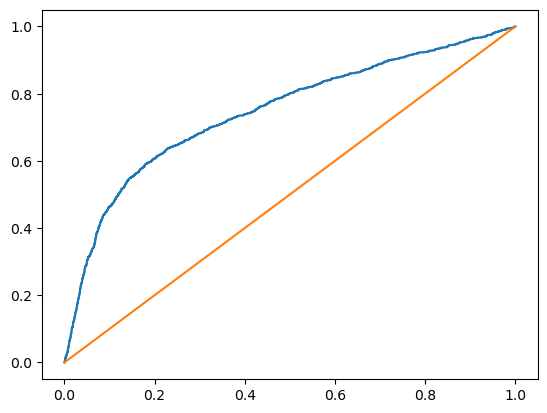

In [45]:
fpr,tpr,_=roc_curve(ytest,pred)
score=roc_auc_score(ytest,pred)
plt.plot(fpr,tpr,label="Validation score: "+str(score))
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')

In [46]:
pred1=l.predict(xtest)
cm=confusion_matrix(ytest,pred1)
cm

array([[7580,  128],
       [1579,  174]], dtype=int64)

In [47]:
norm_cm=cm.astype(float)/cm.sum(axis=1)[:,np.newaxis]

<Axes: >

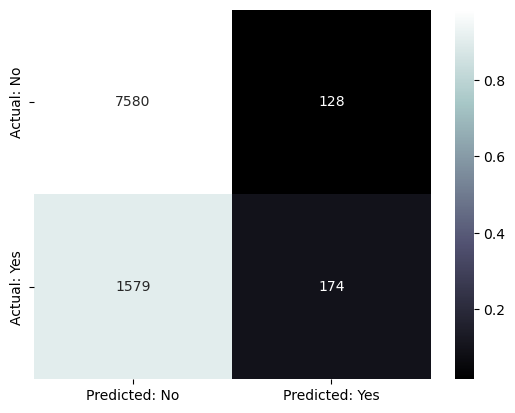

In [48]:
sns.heatmap(norm_cm,annot=cm,fmt='g',xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'],cmap="bone")

In [49]:
recall_score(ytest,pred1)

0.09925841414717627

In [50]:
df.head()

,vintage,age,gender,dependents,city,customer_nw_category,branch_code,days_since_last_transaction,vintage_in_yrs,occupation_company,...,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,3135,66,1.0,0.0,187.0,2,755,224.0,8.589041,0,...,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,310,35,1.0,0.0,1020.0,2,3214,60.0,0.849315,0,...,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,2356,31,1.0,0.0,146.0,2,41,999.0,6.454795,0,...,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,478,90,-1.0,0.0,1020.0,2,582,147.0,1.309589,0,...,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,2531,42,1.0,2.0,1494.0,3,388,58.0,6.934247,0,...,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732


In [51]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    dff=df[cols]
    cv=[]
    i=1
    kf=StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(dff,y):
        xtr,xval=dff.loc[df_index],dff.loc[test_index]
        ytr,yval=y.loc[df_index],y.loc[test_index]
        print("\n{} of KFold{}".format(i,kf.n_splits))
        
        model=ml_model
        model.fit(xtr,ytr)
        pred_pr=model.predict_proba(xval)
        pp=[]
        
        for j in pred_pr[:,1]:
            if j > thres:
                pp.append(1)
            else:
                pp.append(0)
        
        score=roc_auc_score(yval,pred_pr[:,1])
        recall=recall_score(yval,pp)
        precision=precision_score(yval,pp)
        
        print("ROC_AUC_SCORE {:.4f} Recall Score {} Precision Score {:.4f}".format(score,recall,precision))

        cv.append(score)
        i+=1
    return cv

In [52]:
baseline=cv_score(LogisticRegression(),cols=cols)


1 of KFold5
ROC_AUC_SCORE 0.7498 Recall Score 0.10931558935361217 Precision Score 0.5808

2 of KFold5
ROC_AUC_SCORE 0.7559 Recall Score 0.10456273764258556 Precision Score 0.6548

3 of KFold5
ROC_AUC_SCORE 0.7402 Recall Score 0.10551330798479087 Precision Score 0.5873

4 of KFold5
ROC_AUC_SCORE 0.7482 Recall Score 0.09600760456273764 Precision Score 0.5805

5 of KFold5
ROC_AUC_SCORE 0.7438 Recall Score 0.10171102661596958 Precision Score 0.5847


In [53]:
baseline

[0.7498170794368513,
 0.7559097728907614,
 0.740242263870433,
 0.7481864334863895,
 0.743765171300012]

In [54]:
all_f=cv_score(LogisticRegression())


1 of KFold5
ROC_AUC_SCORE 0.7717 Recall Score 0.16159695817490494 Precision Score 0.6911

2 of KFold5
ROC_AUC_SCORE 0.7514 Recall Score 0.094106463878327 Precision Score 0.7071

3 of KFold5
ROC_AUC_SCORE 0.7610 Recall Score 0.15779467680608364 Precision Score 0.6748

4 of KFold5
ROC_AUC_SCORE 0.7370 Recall Score 0.0779467680608365 Precision Score 0.5655

5 of KFold5
ROC_AUC_SCORE 0.7383 Recall Score 0.11026615969581749 Precision Score 0.5604


In [55]:
#RECURSIVE ELIMINATION
from sklearn.feature_selection import RFE
model=LogisticRegression()
rfe=RFE(estimator=model,n_features_to_select=1,step=1)
rfe.fit(df,y)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [56]:
ranking=pd.DataFrame()
ranking['Features']=df.columns
ranking['rank']=rfe.ranking_

In [57]:
rank=ranking.sort_values(by='rank')

In [58]:
rank

,Features,rank
14,current_balance,1
17,average_monthly_balance_prevQ,2
9,occupation_company,3
16,average_monthly_balance_prevQ2,4
22,current_month_balance,5
23,previous_month_balance,6
20,current_month_debit,7
10,occupation_retired,8
5,customer_nw_category,9
21,previous_month_debit,10


In [59]:
rfetop10=cv_score(LogisticRegression(),cols=rank['Features'][:10].values)


1 of KFold5
ROC_AUC_SCORE 0.7983 Recall Score 0.24049429657794677 Precision Score 0.7355

2 of KFold5
ROC_AUC_SCORE 0.8033 Recall Score 0.2252851711026616 Precision Score 0.7548

3 of KFold5
ROC_AUC_SCORE 0.7992 Recall Score 0.22813688212927757 Precision Score 0.7251

4 of KFold5
ROC_AUC_SCORE 0.7960 Recall Score 0.21292775665399238 Precision Score 0.7320

5 of KFold5
ROC_AUC_SCORE 0.7945 Recall Score 0.19296577946768062 Precision Score 0.6744


In [60]:
cv_score(LogisticRegression(),cols=rank['Features'][:10].values,thres=0.2)# taking threshold closer to churn % in the model


1 of KFold5
ROC_AUC_SCORE 0.7983 Recall Score 0.6749049429657795 Precision Score 0.5039

2 of KFold5
ROC_AUC_SCORE 0.8033 Recall Score 0.6977186311787072 Precision Score 0.5300

3 of KFold5
ROC_AUC_SCORE 0.7992 Recall Score 0.6758555133079848 Precision Score 0.5247

4 of KFold5
ROC_AUC_SCORE 0.7960 Recall Score 0.69106463878327 Precision Score 0.5141

5 of KFold5
ROC_AUC_SCORE 0.7945 Recall Score 0.6673003802281369 Precision Score 0.5181


[0.7982939060733737,
 0.8033314150652554,
 0.7991813254042391,
 0.7959758229505178,
 0.7944593096688463]

# Comparison of different models

baseline model
all feature model
model based on top 10 features

In [61]:
results_df=pd.DataFrame({'baseline':baseline,'all feature':all_f,'Top 10 Ranked':rfetop10})

<Axes: >

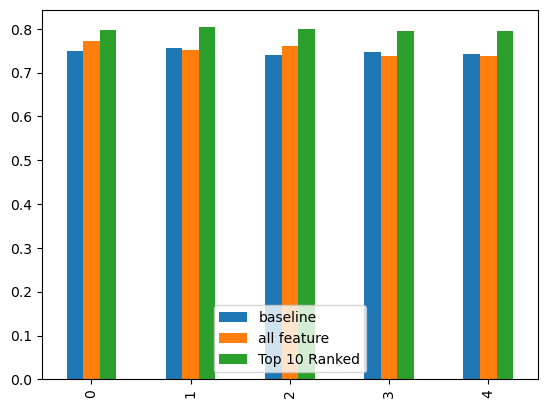

In [62]:
results_df.plot(y=['baseline','all feature','Top 10 Ranked'],kind='bar')

Here, we can see that the model based on RFE is giving the best result for each fold.